In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from tqdm import tqdm

In [2]:
# Генерируем две случайные выборки с биномиальным распределением, которые принадлежат одной генеральной совокупности.
# Проводим Z-тест. P-value должно быть близкое к единице т.к. выборки принадлежат одной совокупности.
# Повторяем 1000 раз, смотрим какая доля тестов с P-value менее 0.05

In [3]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 1000)
    b = np.random.binomial(1, 0.03, 1000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result < 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 3667.46it/s]

0.051


In [4]:
# Видим, что доля тестов с P-value <= 0.05 около 5%. Значит в 5% случаев тест находит разницу там, где ее на самом деле нет.
# Или можно сказать, что тест в 95% верно определяет, что разницы нет. Такая вероятность в статистике определяется значением параметра alpha.
# Например, если alpha = 0.05 мы принимаем погрешность, что 5% случаев мы будем отвергать верную нулевую гипотезу.

<AxesSubplot:>

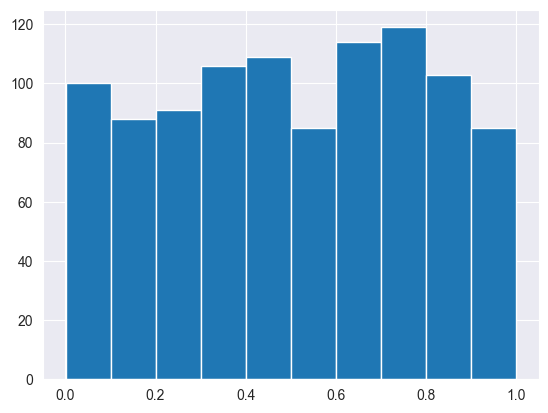

In [5]:
# Построим гистограмму распределения P-value
result.hist()

In [6]:
# Изменим условия. Смоделируем ситуацию, когда выборки не принадлежат одной генеральной совокупности.
# Посмотрим, какая доля тестов будет с P-value > 0.05.

In [7]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 1000)
    b = np.random.binomial(1, 0.035, 1000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result >= 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 3780.98it/s]

0.91


In [8]:
# Тест в 90% случаев показывает, что выборки принадлежат одной генеральной совокупности, хотя это не так. Такая ситуация в статистике называется
# ошибка второго рода, когда мы принимаем неверную нулевую гипотезу. Можно переформулировать, что мы не смогли обнаружить отличия там где они есть.
# Параметр, который отвечает за вероятность найти отличия в ситуации когда они есть называется мощность. В нашем случае он равен 10%, что очень мало.
# Предположим, что тест не может определить изменение в 0.5 процентных пункта на выборках в 1000 наблюдений.

In [9]:
# Изменим условия теста: увеличим размер выборки до 10 000 наблюдений, P-value <= 0.05

In [10]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 10000)
    b = np.random.binomial(1, 0.035, 10000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result < 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 1875.62it/s]

0.509


In [11]:
# Уже лучше. Тест дает ложноположительный результат примерно в 50% случаев. Увеличиваем размер выборки до 20 000 наблюдений.

In [12]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 20000)
    b = np.random.binomial(1, 0.035, 20000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result < 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 1125.87it/s]

0.801


In [13]:
# Тест верно определяет разницу между выборками в 80% случаев. Что же неплохо. В статистике power=80% считается приемлемым.

<AxesSubplot:>

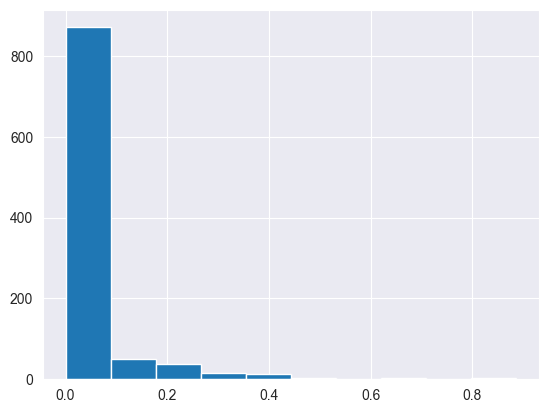

In [14]:
# Построим гистограмму распределения
result.hist()

In [15]:
# Итак, методом тыка мы нашли необходимый размер выборки в 20 000 наблюдений. Вывод: размер выборки влияет на точность теста.
# Попробуем более научный подход определения размера выборки. Для этого используем statsmodels.stats.power. NormalIndPower.solve_power
# Тест на вход принимает параметры: ожидаемое изменение, размер контрольной выборки, alpha, power, соотношение контрольной и тестовой групп,
# тип теста: меньше, больше или двухсторонний. Тест возвращает параметр, который не определен. Например, нам нужно узнать размер выборки.
# Не будет его указывать.

In [16]:
es = sms.proportion_effectsize(0.03, 0.035)
sample_size = round(sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))
print(es)
print(sample_size)

-0.02821746104476741
19715


In [17]:
# Для генерации выборок мы использовали биномиальное распределение, для вычисления P-value использовали Z-тест.
# Попробуем другие тесты.

In [18]:
# Первый в нашей очереди T-тест. Используем ttest_ind из библиотеки scipy.stats. Тест принимает параметры: a, b это две выборки,
# которые содержат положительные и отрицательные результаты, в нашем случае массив из нулей и единиц [1, 0, 0, 0, 1], equal_var — по умолчанию False.
# False — выборки принадлежат одной генеральной совокупности с одинаковой дисперсией, используется обычный T-тест, True — выборки принадлежат
# разным генеральным совокупностям, используется T-тест Уэлча.
# !!! Обрати внимание, equal_var=False

In [19]:
result = []
a_st_dev = []
b_st_dev = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    a_st_dev.append(np.std(a))
    b = np.random.binomial(1, 0.03, 19715)
    b_st_dev.append(np.std(b))
    p_value = ttest_ind(a, b, equal_var=False)[1]
    result.append(p_value)
a_result = pd.Series(a_st_dev)
b_result = pd.Series(b_st_dev)
result = pd.Series(result)
print('Среднее стандартное отклонение для группы A:', a_result.mean())
print('Среднее стандартное отклонение для группы B:', b_result.mean())
print('alpha=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:01<00:00, 660.00it/s]

Среднее стандартное отклонение для группы A: 0.17041531990375836
Среднее стандартное отклонение для группы B: 0.17065967041393681
alpha=0.051


<AxesSubplot:>

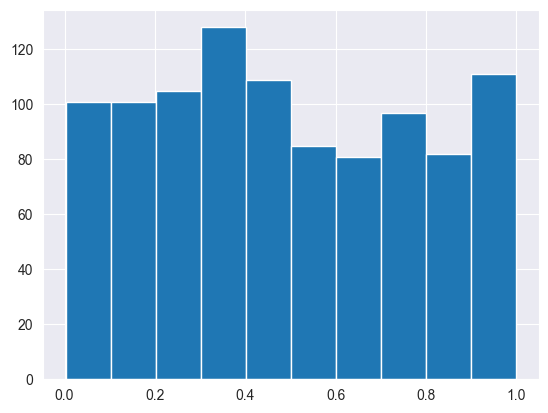

In [20]:
result.hist()

In [21]:
result = []
a_st_dev = []
b_st_dev = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    a_st_dev.append(np.std(a))
    b = np.random.binomial(1, 0.035, 19715)
    b_st_dev.append(np.std(b))
    p_value = ttest_ind(a, b, equal_var=True)[1]
    result.append(p_value)
a_result = pd.Series(a_st_dev)
b_result = pd.Series(b_st_dev)
result = pd.Series(result)
print('Среднее стандартное отклонение для группы A:', a_result.mean())
print('Среднее стандартное отклонение для группы B:', b_result.mean())
print('power=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:01<00:00, 739.82it/s]

Среднее стандартное отклонение для группы A: 0.17047810428210555
Среднее стандартное отклонение для группы B: 0.18374722738727667
power=0.808


<AxesSubplot:>

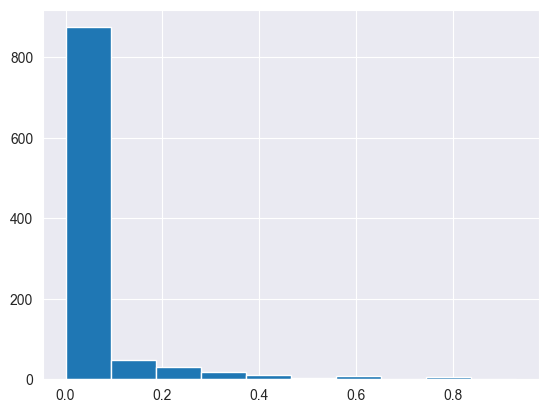

In [22]:
result.hist()

In [23]:
# Вывод T-тест дает схожие показатели alpha и power, распределение P-value

In [24]:
# Для разнообразия попробуем непараметрический U-тест Манна-Уитни. Он хорош для малых выборок или когда есть значительные выбросы (высокая дисперсия)
# или для анализа непрерывных переменных

In [25]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    b = np.random.binomial(1, 0.03, 19715)
    p_value = mannwhitneyu(a, b)[1]
    result.append(p_value)
result = pd.Series(result)
print('alpha=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:24<00:00, 40.94it/s]

alpha=0.048


In [26]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    b = np.random.binomial(1, 0.035, 19715)
    p_value = mannwhitneyu(a, b)[1]
    result.append(p_value)
result = pd.Series(result)
print('power=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]

power=0.809


In [27]:
# Манн-Уитни дал схожие результаты.

In [28]:
# А теперь очень интересное наблюдение. Возьмем нормальное распределение и сделаем T-test

In [29]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.normal(0.03, 0.017, 19715)
    b = np.random.normal(0.035, 0.018, 19715)
    p_value = ttest_ind(a, b, equal_var=True)[1]
    result.append(p_value)
result = pd.Series(result)
print('power=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:01<00:00, 576.85it/s]

power=1.0


In [30]:
# Мы видим мощность в 100% Почему так получилось? Метод random.normal генерирует и нормально распределяет нам средние. В нашем примере получается,
# что мы взяли 19715 выборок из генеральной совокупности, посчитали среднее для каждой выборки, получили их P-value и так проделали 1000 раз.

In [31]:
# Найдем необходимый размер выборки для нормального распределения. В этом нам поможет TTestIndPower.solve_power, он аналогичен
# NormalIndPower.solve_power. Разница в том, что TTestIndPower для Т-теста, NormalIndPower для Z-теста. Для расчета effect size воспользуемся
# формулой (X̄a - X̄b) / standard deviation

In [32]:
es = (0.035 - 0.03) / 0.017
sample_size = round(sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))
print('sample_size:', sample_size)

sample_size: 182


In [33]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.normal(0.03, 0.017, 182)
    b = np.random.normal(0.03, 0.017, 182)
    p_value = ttest_ind(a, b, equal_var=True)[1]
    result.append(p_value)
result = pd.Series(result)
print('alpha=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:00<00:00, 3550.71it/s]

alpha=0.046


In [34]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.normal(0.03, 0.017, 182)
    b = np.random.normal(0.035, 0.018, 182)
    p_value = ttest_ind(a, b, equal_var=True)[1]
    result.append(p_value)
result = pd.Series(result)
print('power=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:00<00:00, 3378.58it/s]

power=0.754


In [35]:
# Очень важно! Для расчета размера выборки при биномиальном распределении effect size считаем с помощью proportion_effectsize,
# для стандартного распределения с помощью формулы (X̄a - X̄b) / standard deviation!

In [36]:
# Попробуем на реальных данных понять тип распределения. Возьмем 100 выборок по 700 наблюдений в каждой.

In [37]:
data_frame = pd.read_csv('/Users/mitya/Downloads/cr_export.csv', sep=',', header=None)

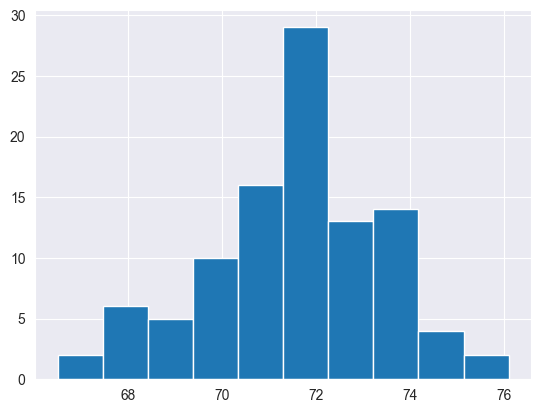

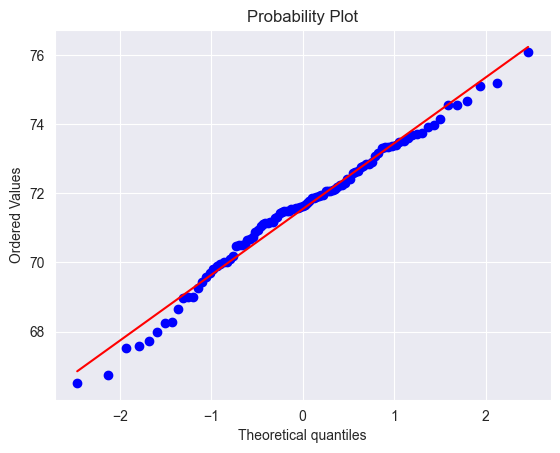

In [38]:
bounce_rate = data_frame[0]
bounce_rate.hist()
plt.show()
stats.probplot(bounce_rate, dist="norm", plot=plt)
plt.show()

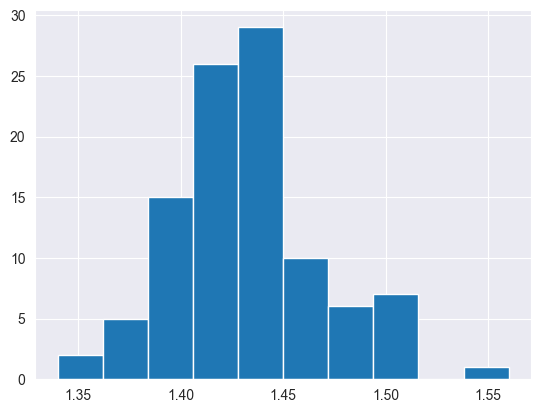

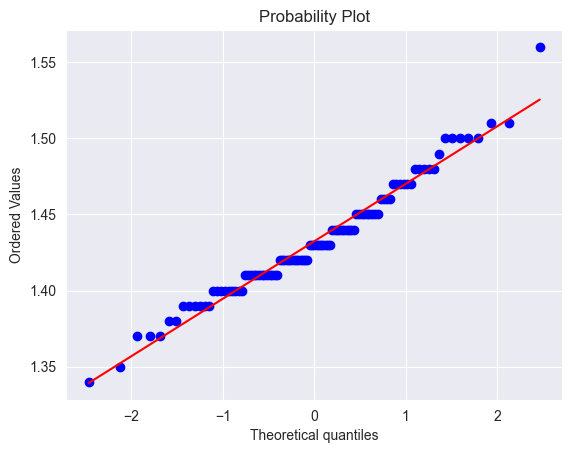

In [39]:
page_view = data_frame[1]
page_view.hist()
plt.show()
stats.probplot(page_view, dist="norm", plot=plt)
plt.show()

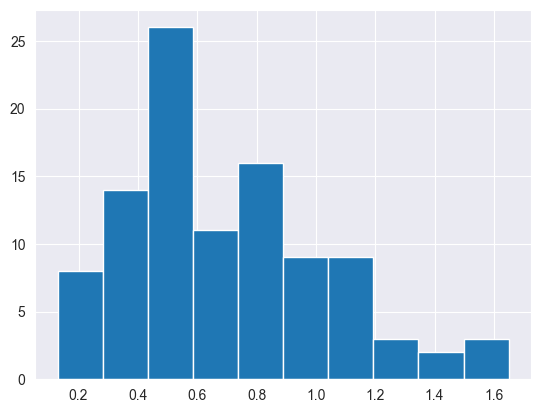

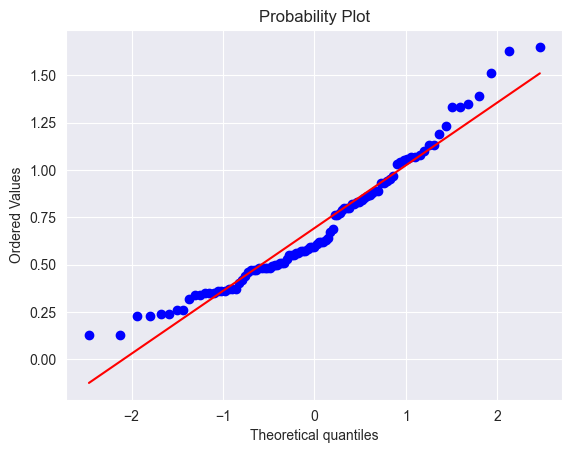

In [40]:
cr_order = data_frame[2]
cr_order.hist()
plt.show()
stats.probplot(cr_order, dist="norm", plot=plt)
plt.show()

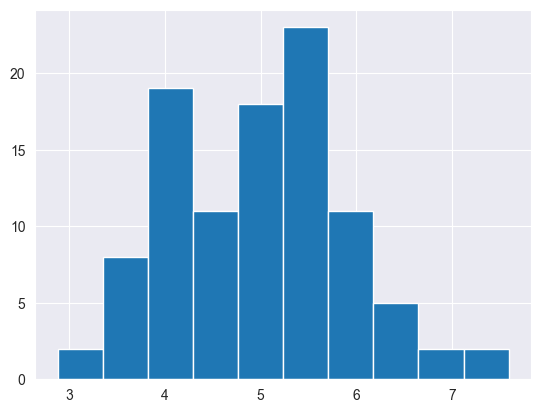

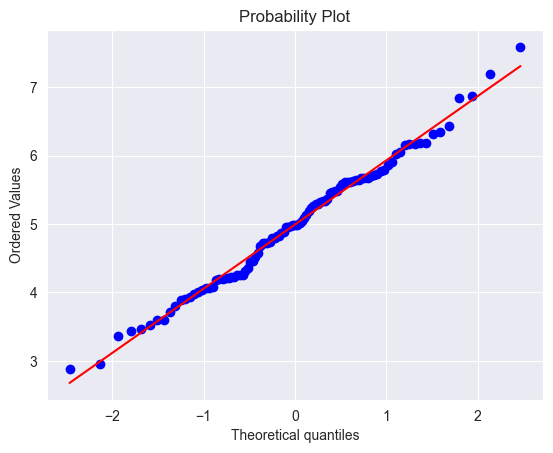

In [41]:
cr_all_forms = data_frame[3]
cr_all_forms.hist()
plt.show()
stats.probplot(cr_all_forms, dist="norm", plot=plt)
plt.show()

In [42]:
# Теперь возьмем 100 выборок по 10 000 наблюдений в каждой.

In [43]:
data_frame = pd.read_csv('/Users/mitya/Downloads/cr_export_1.csv', sep=',', header=None)

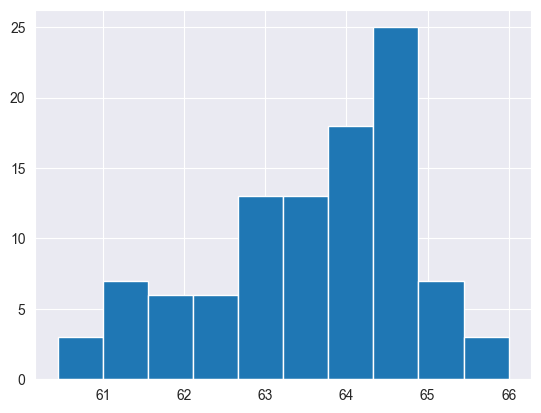

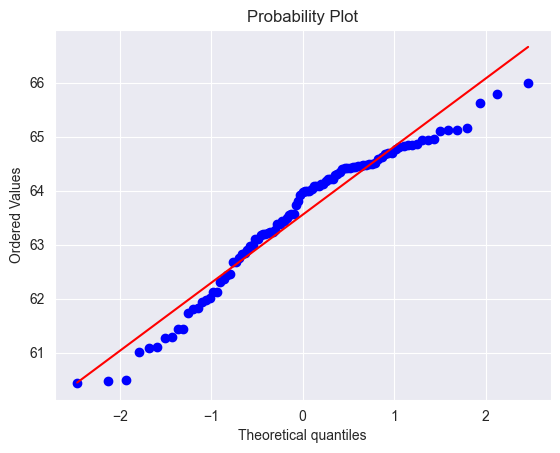

In [44]:
bounce_rate_1 = data_frame[0]
bounce_rate_1.hist()
plt.show()
stats.probplot(bounce_rate_1, dist="norm", plot=plt)
plt.show()

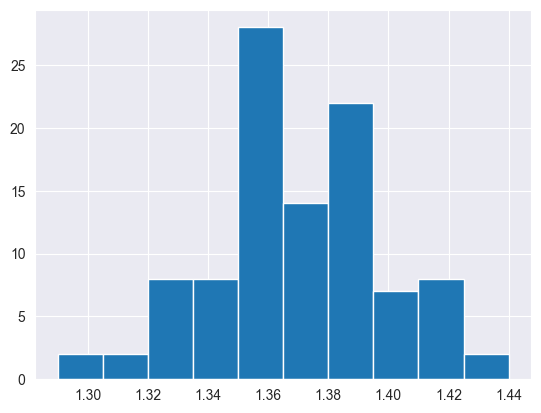

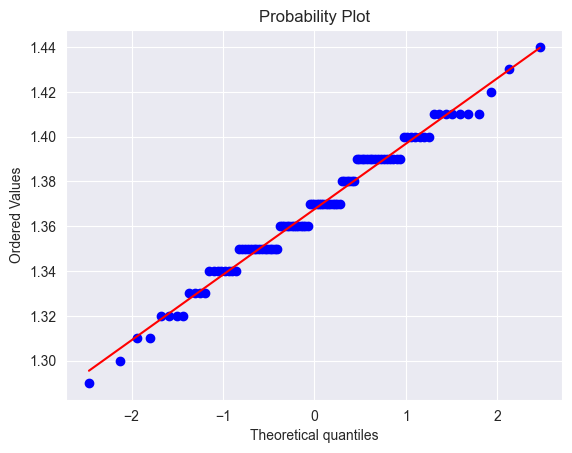

In [45]:
page_view_1 = data_frame[1]
page_view_1.hist()
plt.show()
stats.probplot(page_view_1, dist="norm", plot=plt)
plt.show()